In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
#hyperfine reduced matrix element <F||d||F'>
def __Fg_d_Fe(Jg_d_Je, Fg, Fe, Jg, Je, I):
    return (
    Jg_d_Je * (-1)**(Fe+Jg+1+I) * 
        np.sqrt( (2*Fe+1)*(2*Jg+1) ) 
        * wigner_6j(Jg, Je, 1, Fe, Fg, I)
    )

In [3]:
#reduced matrix element <Jg||d||Je>
def __Jg_d_Je(omega_0, Jg, Je, tau):
    return np.sqrt(
        3*np.pi*epsilon0*hbar*c**3/omega_0**3/tau
        * (2*Je+1)/(2*Jg+1)
    )

In [4]:
def Rabi_clock(Fg, Fe, mg, me, d, pol):
    q = -(me-mg)
    Jg_d_Je = d
    
    CG_coeff = float(CG(Fe, me, 1, q, Fg, mg).doit())
    
    Eplus = pol * np.sqrt( intensity / 2 / epsilon0 / c)
    
    return (
    -2 * Jg_d_Je / hbar * Eplus * CG_coeff
    )
    

In [5]:
wH = 0.025e-3
wV = wH
P = 0.6*80e-3
intensity = 2*P/np.pi/wV/wH
d = 4.5*hbar

In [6]:
Rabi_clock(1/2, 1/2, 1/2, -1/2, 4.5*hbar,  1)/1e6/2/np.pi

0.11223749592894952

In [7]:
Rabi_clock(1/2, 1/2, 1/2, 1/2, 4.5*hbar,  1)/1e6/2/np.pi

-0.07936389447475771

In [8]:
_lambda = 578e-9
omega_r = 2*np.pi*8e3
m = 171*u
tau = 22

k = 2*np.pi/_lambda #momentum kick 
x0 = np.sqrt(hbar/2/m/omega_r) #oscillator length
LambDicke = x0*k #Lamb-Dicke parameters
print('Lamb-Dicke parameter (eta): ', LambDicke)
print('eta^2 (2n+1): ', LambDicke**2, '(2n+1)')
print('Max n for Lamb-Dicke regime: n = ', floor(((1/LambDicke**2)-1)/2))

Lamb-Dicke parameter (eta):  0.6607201946347716
eta^2 (2n+1):  0.4365511755982105 (2n+1)
Max n for Lamb-Dicke regime: n =  0


In [9]:
N=20 #keep HO states up to N 

one = basis(4,0)
two = basis(4,1)
three = basis(4,2)
four = basis(4,3)
ground = fock(N, 0)

a = qutip.tensor(destroy(N), identity(4))
adag = qutip.tensor(create(N), identity(4))

sig_11 = qutip.tensor(identity(N),one*one.dag())
sig_22 = qutip.tensor(identity(N),two*two.dag())
sig_33 = qutip.tensor(identity(N),three*three.dag())
sig_44 = qutip.tensor(identity(N),four*four.dag())

sig_14 = qutip.tensor(identity(N),one*four.dag())
sig_41 = qutip.tensor(identity(N),four*one.dag())

sig_13 = qutip.tensor(identity(N),one*three.dag())
sig_31 = qutip.tensor(identity(N),three*one.dag())

sig_24 = qutip.tensor(identity(N),two*four.dag())
sig_42 = qutip.tensor(identity(N),four*two.dag())

sig_23 = qutip.tensor(identity(N),two*three.dag())
sig_32 = qutip.tensor(identity(N),three*two.dag())

In [10]:
psi0 = (two)
psii = (three)
rhoi = psii*psii.dag()
i_proj = qutip.tensor(identity(N), rhoi)
ground_proj = qutip.tensor(ground*ground.dag(), identity(4))

In [11]:
T=1e-6 #initial temperature
omega_r_deep = 2*np.pi*63e3
n_start =1/(np.exp(hbar*omega_r_deep/T/kB)-1)
rho0 = qutip.tensor(thermal_dm(N, n_start), psi0*psi0.dag()) #start in up thermal state
print(isherm(rho0))
print('n_start: ', n_start)
print('ground state population', (rho0*ground_proj).tr())

True
n_start:  0.05111530367346818
ground state population 0.9513704124610985


In [12]:
B = 6.8*4.8e-4/20 #magnetic field in T
print('Magnetic field B', B*1e4, 'G')

delta_Ne = -2*np.pi*582*B*1e4 #excited
delta_Ng = -2*np.pi*375*B*1e4 #ground
Fg=1/2
Fe=1/2

Magnetic field B 1.6320000000000001 G


In [13]:
dt = 1e-8
t_ls = np.arange(0, 1000*dt, dt)

In [14]:
#diagonal terms
diag_1 = -delta_Ng

diag_2 = delta_Ng

diag_3 = -delta_Ne

diag_4 = delta_Ne

In [15]:
def Hp_coeff(t, args):
    return np.exp(1j*delta*t)

def Hm_coeff(t, args):
    return np.exp(-1j*delta*t)

In [16]:
phi = -np.pi/2
angle_pol = (np.pi/4) 
impurity = 2e-2

## polarization ##
##################

#basis
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

xb = np.array([np.sqrt(1-impurity),impurity,0])
yb = np.array([-impurity,np.sqrt(1-impurity),0])
zb = np.array([0,0,1])

polarization = (np.cos(angle_pol)*xb+np.sin(angle_pol)*np.exp(-1j*phi)*zb)

pi_pol = y
sigp_pol = 1/np.sqrt(2)*(z-1j*x)
sigm_pol = -1/np.sqrt(2)*(z+1j*x)

#off-diagonal terms
offdiag_31 = Rabi_clock(Fg, Fe, -1/2, -1/2, d, np.dot(polarization, pi_pol)) / 2
offdiag_41 = Rabi_clock(Fg, Fe, -1/2, 1/2, d, np.dot(polarization, sigp_pol)) / 2
offdiag_32 = Rabi_clock(Fg, Fe, 1/2, -1/2, d, np.dot(polarization, sigm_pol)) / 2
offdiag_42 = Rabi_clock(Fg, Fe, 1/2, 1/2, d, np.dot(polarization, pi_pol)) / 2

offdiag_14 = np.conjugate(offdiag_41)
offdiag_13 = np.conjugate(offdiag_31)
offdiag_24 = np.conjugate(offdiag_42)
offdiag_23 = np.conjugate(offdiag_32)

delta = -(delta_Ng+delta_Ne)

H0 = diag_1*sig_11 + diag_2*sig_22 + diag_3*sig_33 + diag_4*sig_44

Hm = omega_r*(adag*a + 1/2)

H1_diag = H0+Hm

H1_offdiag = (offdiag_13*sig_13 +  offdiag_14*sig_14 +
                                       offdiag_24*sig_24 + offdiag_23*sig_23)*( (1j*LambDicke*(adag+a)).expm())

H1_conj = (offdiag_31*sig_31 + offdiag_41*sig_41
                                        + offdiag_42*sig_42 + offdiag_32*sig_32)*( (-1j*LambDicke*(adag+a)).expm())

c_ops = []

options = qutip.solver.Options(nsteps=100000)

output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho0, t_ls, 
                      c_ops, options=options)

In [17]:
offdiag_41/offdiag_32, 1/200

((0.005050633883346561-3.061538899378514e-17j), 0.005)

In [18]:
rho_ls = output.states

P = [(i_proj*rho).tr()  for rho in rho_ls]
Pg = [(ground_proj*rho).tr()  for rho in rho_ls]

max fidelity: 0.9964
4.47e-06 1e-08


(0.99, 1.0)

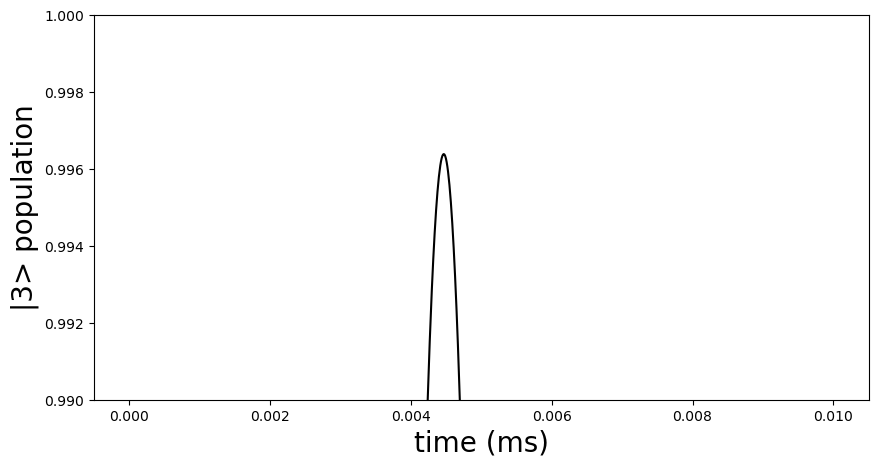

In [19]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, np.array(P), color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'|3> population', fontsize=20)
print('max fidelity: %.4f' %np.max(abs(np.array(P))))
axes.set_ylim(0,1)

pi_time_idx = np.argwhere(abs(np.array(P))==np.max(abs(np.array(P))))
pi_time = t_ls[pi_time_idx][0][0]
print(pi_time, dt)
axes.set_ylim(0.99, 1)

(0.6, 1.0)

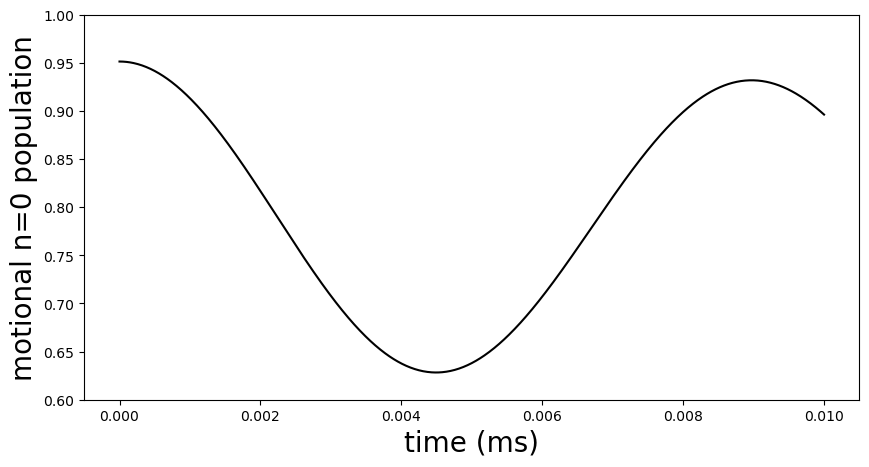

In [20]:
fig, axes = plt.subplots(1,1, dpi=100, sharex=True, figsize=(10,5))
axes.plot(t_ls*1e3, Pg, color='k', linestyle='-', label = 'mF=-1/2')
axes.set_xlabel(r'time (ms)', fontsize=20)
axes.set_ylabel(r'motional n=0 population', fontsize=20)
axes.set_ylim(0.6, 1)
#axes.set_xlim(0, 0.01)

# Trap loss MC

In [21]:
U = 8.8*(0.2/7.62)*1e6 #trap deph in Hz

In [32]:
Ntraj = 100
pi_time = 4.47e-06

tau_ls = []
count_ls = []
for nt in range(Ntraj):
    t = 0
    tf = 0.5e-3
    dt = pi_time
    
    print(nt)
    
    count = []
    
    rho = rho0
    
    while t<tf:
        output = mesolve([H1_diag, [H1_offdiag, Hp_coeff], [H1_conj, Hm_coeff]], rho, 
                         np.arange(t, t+dt, dt/50), c_ops, [a.dag()*a], options=options)
        rho = output.states[-1]
        nbar_temp = output.expect[0][-1]
        E = hbar*omega_r*(nbar_temp+1/2)
        eps = random.random()

        if (np.exp(-h*U/E) > eps):
            tau = t
            for idx in range(int((tf-t)/dt)+1):
                count.append(0)
            t = tf
            
        else:
            t += dt
            count.append(1)
            
    count_ls.append(count)
            
    tau_ls.append(tau)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [43]:
def decay_fit(t, tau):
    return np.exp(-t/tau)

In [44]:
popt, pcov = curve_fit(decay_fit, np.arange(0, tf, dt), 
                       np.mean(count_ls, axis=0), p0=1500e-6)

In [45]:
print(popt)

[1892896.57743949]


In [46]:
3/60

0.05

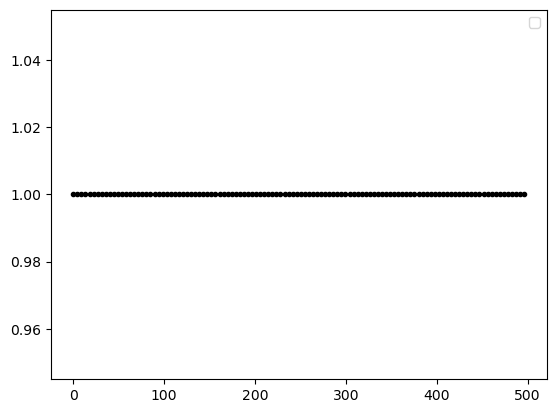

In [47]:
plt.plot(np.arange(0, tf, dt)*1e6, np.mean(count_ls, axis=0), 'k.')
fine = np.linspace(0, tf, 1000)
fit = decay_fit(fine, *popt)
#plt.plot(fine*1e6, fit, label='tau = %.2f us' %(popt*1e6))
plt.legend()

7999.999999999999
[0.00000000e+00 1.51515152e-06 3.03030303e-06 4.54545455e-06
 6.06060606e-06 7.57575758e-06 9.09090909e-06 1.06060606e-05
 1.21212121e-05 1.36363636e-05 1.51515152e-05 1.66666667e-05
 1.81818182e-05 1.96969697e-05 2.12121212e-05 2.27272727e-05
 2.42424242e-05 2.57575758e-05 2.72727273e-05 2.87878788e-05
 3.03030303e-05 3.18181818e-05 3.33333333e-05 3.48484848e-05
 3.63636364e-05 3.78787879e-05 3.93939394e-05 4.09090909e-05
 4.24242424e-05 4.39393939e-05 4.54545455e-05 4.69696970e-05
 4.84848485e-05 5.00000000e-05 5.15151515e-05 5.30303030e-05
 5.45454545e-05 5.60606061e-05 5.75757576e-05 5.90909091e-05
 6.06060606e-05 6.21212121e-05 6.36363636e-05 6.51515152e-05
 6.66666667e-05 6.81818182e-05 6.96969697e-05 7.12121212e-05
 7.27272727e-05 7.42424242e-05 7.57575758e-05 7.72727273e-05
 7.87878788e-05 8.03030303e-05 8.18181818e-05 8.33333333e-05
 8.48484848e-05 8.63636364e-05 8.78787879e-05 8.93939394e-05
 9.09090909e-05 9.24242424e-05 9.39393939e-05 9.54545455e-05
 9.696

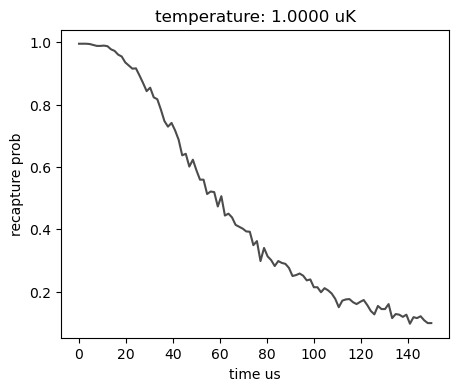

In [115]:
#monte-carlo for temp measurement
from numpy import random
from scipy.stats import norm
import scipy.constants as sc
kB=sc.k #boltzmann cont
pi=np.pi
c=sc.c
h=sc.h
g=sc.g
eps0 = sc.epsilon_0
au=sc.physical_constants['atomic mass constant'][0]

m = 171*au #mass
_lambda = 759e-9 #532 wavelength
w0 = 0.8e-6
zR = pi*w0**2/ _lambda #Rayleigh range
U = h*0.23e6

_lambdaClock = 578e-9
Erecoil = h**2/_lambdaClock/2/m

############
omg_r = 2*np.pi*8e3
omg_ax = omg_r*w0/zR/np.sqrt(2)

g = scipy.constants.g

print(omg_r/2/pi)

def KE(vx, vy, vz):
    return(m*(vx**2+vy**2+vz**2)/2)

def PE(x, y, z):
    return -U*(1 - 2*(x**2+y**2)/w0**2 - (z/zR)**2)

def scaled_prob(prob, a):
    return prob*a

# experimental data
t_array = np.linspace(0, 150e-6, 100)

print(t_array)

T = 1e-6
Ntraj = 1000
recapture_prob_array = []

v_std = np.sqrt(kB*T/m)
v_array = np.linspace(-5*v_std, 5*v_std, 100000)
rpos_std = np.sqrt(kB*T/m/omg_r**2)
rpos_array = np.linspace(-5*rpos_std, 5*rpos_std, 100000)
axpos_std = np.sqrt(kB*T/m/omg_ax**2)
axpos_array = np.linspace(-5*axpos_std, 5*axpos_std, 100000)
for i in range(len(t_array)):
    dt = t_array[i]
    n=0
    recapture = 0

    xs = norm.rvs(size=Ntraj, scale=rpos_std)
    ys = norm.rvs(size=Ntraj, scale=rpos_std)
    zs = norm.rvs(size=Ntraj, scale=axpos_std)
    vxs = norm.rvs(size=Ntraj, scale=v_std)
    vys = norm.rvs(size=Ntraj, scale=v_std)
    vzs = norm.rvs(size=Ntraj, scale=v_std)

    while n<Ntraj:

        xi = xs[n]
        yi = ys[n]
        zi = zs[n]
        vx = vxs[n]
        vy = vys[n]
        vz = vzs[n]

        xf = xi + vx*dt
        yf = yi + vy*dt
        zf = zi + vz*dt - g*dt**2

        Etot = KE(vx, vy, vz) + PE(xf, yf, zf) + n*Erecoil

        if Etot < 0:
            recapture = recapture + 1
        else: 
            recapture = recapture

        n = n+1

    recapture_prob = recapture/Ntraj
    recapture_prob_array.append(recapture_prob)

fig, ax = plt.subplots(figsize=[5,4])
plt.plot(t_array*1e6, recapture_prob_array, 'k-', alpha=0.7, label='Monte-Carlo')
plt.xlabel('time us')
plt.ylabel('recapture prob')
plt.title('temperature: %.4f uK' %(T*1e6))
plt.show()